<a href="https://colab.research.google.com/github/bradleywjenks/CIVE_70019_70057/blob/main/notebooks/coursework_part1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Coursework: Hydraulic model calibration (Part 1)


### CIVE 70019/70057
Department of Civil and Environmental Engineering, Imperial College London

You have been tasked with the evaluation and calibration of the hydraulic model of EXNING, a district metered area (DMA) in Anglian Water's (AW) water distribution network. To achieve this, you have been provided:
* a hydraulic model of the EXNING DMA, in use by Anglian Water in early 2019 (no record of recent calibration),
* pipe groups (based on material & age) and corresponding ranges of H-W coefficients,
* hourly loading conditions (demands, reservoir heads) and head measurements covering a period of 4 days.

The objective of the coursework is to prepare a short calibration report for AW by completing the tasks below and answering the questions (max. 100-150 words per question) based on your results. Don't forget to include titles, labels and legends in your plots, and watch for significant figures in your reporting!

You have been provided the following information about EXNING:
* EXNING is part of a larger system of cascading DMAs: EXNING is fed by the NEWSEV DMA and feeds into the BURWEL DMA.
* According to AW's existing records, EXNING contains mostly old, cast iron pipes.
* The "reservoir" head  and total demand of EXNING are derived from flow and pressure sensors at the DMA inlet (& outlet).
* Node elevations have been updated in the provided model following a GPS survey of sensor locations.

First, we must clone the GitHub repository and install dependencies (only run this once).

In [1]:
# run this cell once
import sys
import os

if 'google.colab' in sys.modules:
  !git clone https://github.com/bradleywjenks/CIVE_70019_70057.git
  !pip install wntr
  !pip install cvxpy
  !apt-get install libsuitesparse-dev && pip install scikit-sparse

Cloning into 'CIVE_70019_70057'...
remote: Enumerating objects: 765, done.
remote: Counting objects: 100% (515/515), done.
remote: Compressing objects: 100% (237/237), done.
remote: Total 765 (delta 324), reused 447 (delta 278), pack-reused 250 (from 1)
Receiving objects: 100% (765/765), 11.21 MiB | 5.72 MiB/s, done.
Resolving deltas: 100% (474/474), done.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 18.3 MB/s eta 0:00:00
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libamd2 libbtf1 libcamd2 libccolamd2 libcholmod3 libcolamd2 libcxsparse3 libgraphblas-dev
  libgraphblas6 libklu1 libldl2 libmetis5 libmongoose2 librbio2 libsliplu1 libspqr2
  libsuitesparseconfig5 libumfpack5
The following NEW packages will be installed:
  libamd2 libbtf1 libcamd2 libccolamd2 libcholmod3 libcolamd2 libcxsparse3 libgraphblas-dev
  libgraphblas6 libklu1 libldl2 libmetis5 libmongoose2 librbio2 

In [2]:
# load packages
import numpy as np
from numpy import linalg as la
import networkx as nx
import pandas as pd
import wntr
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import copy
from datetime import datetime, timedelta
import cvxpy as cp
import warnings
warnings.filterwarnings('ignore')

# improve matplotlib image quality
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

### Load network properties and operational data

Load functions created in previous assignments.

In [3]:
# load functions from src folder
if 'google.colab' in sys.modules:
    sys.path.append('/content/CIVE_70019_70057/src/')
    from general_functions import *
    from hydraulic_functions import *
else:
    sys.path.append('/home/bradw/workspace/CIVE_70019_70057/src/')
    from general_functions import *
    from hydraulic_functions import *

Load network .inp file and operational data from the module repository's data directory.

In [4]:
if 'google.colab' in sys.modules:
    # if run in Google Colab
    data_dir = '/content/CIVE_70019_70057/data/parameter_estimation/'
    net_dir = '/content/CIVE_70019_70057/data/networks/'
else:
    # replace with local directory
    data_dir = '/home/bradw/workspace/CIVE_70019_70057/data/parameter_estimation/'
    net_dir = '/home/bradw/workspace/CIVE_70019_70057/data/networks/'

net_name = 'exning.inp'
data_name = 'exning_coursework_dataset.npy'

# load operational data
data = np.load(os.path.join(data_dir, data_name), allow_pickle=True).item()
h_data = data['h_data']
sensor_idx = data['sensor_idx'] - 1 # matlab to python index offset
d_data = data['d']
h0_data = data['h0'].reshape(-1, 1).T

# load network properties
wdn = load_network_data(os.path.join(net_dir, net_name))
A12 = wdn.A12
A10 = wdn.A10
net_info = wdn.net_info
link_df = wdn.link_df
node_df = wdn.node_df
demand_df = wdn.demand_df

Plot sensor nodes in network. We provide a plotting function below.

In [6]:
#### DO NOT CHANGE THIS ####
# define plotting function using networkx
def plot_network(wdn, sensor_idx, vals=None, highlight_valves=None):

    # create figure and axis
    fig, ax = plt.subplots(figsize=(10, 7))

    # unload data
    link_df = wdn.link_df
    node_df = wdn.node_df
    net_info = wdn.net_info

    # draw network
    uG = nx.from_pandas_edgelist(link_df, source='node_out', target='node_in')
    pos = {row['node_ID']: (row['xcoord'], row['ycoord']) for _, row in node_df.iterrows()}
    nx.draw(uG, pos, ax=ax, node_size=20, node_shape='o')

    # draw reservoir
    nx.draw_networkx_nodes(
        uG, pos, nodelist=net_info['reservoir_names'],
        node_size=100, node_shape='s', node_color='black', ax=ax
    )

    # draw sensor nodes
    sensor_names = [net_info['junction_names'][i] for i in sensor_idx]
    nx.draw_networkx_nodes(
        uG, pos, nodelist=sensor_names, node_size=100,
        node_shape='o', node_color='red', edgecolors='white', ax=ax
    )

    # reservoir labels
    reservoir_labels = {node: 'Reservoir' for node in net_info['reservoir_names']}
    labels_res = nx.draw_networkx_labels(uG, pos, reservoir_labels, font_size=12, ax=ax)
    for _, label in labels_res.items():
        label.set_y(label.get_position()[1] + 1750)

    # sensor labels
    sensor_labels = {node: str(idx+1) for (idx, node) in enumerate(sensor_names)}
    labels_sen = nx.draw_networkx_labels(uG, pos, sensor_labels, font_size=12, ax=ax)
    for _, label in labels_sen.items():
        label.set_y(label.get_position()[1] + 1750)

    # plot sensor values if provided
    if vals is not None:
        cmap = cm.get_cmap('RdYlGn_r')
        nx.draw_networkx_nodes(
            uG, pos, nodelist=sensor_names, node_size=100,
            node_shape='o', node_color=vals, cmap=cmap, edgecolors='white', ax=ax
        )

        # create color bar
        sm = plt.cm.ScalarMappable(cmap=cmap)
        sm.set_array(vals)
        colorbar = plt.colorbar(sm, ax=ax)
        colorbar.set_label('Mean pressure residual [m]', fontsize=12)

    # highlight link
    if highlight_valves is not None:
        nx.draw_networkx_nodes(uG, pos, highlight_valves, node_size=200, node_shape='d', node_color='limegreen', edgecolors='white')

    # display plot
    plt.show()

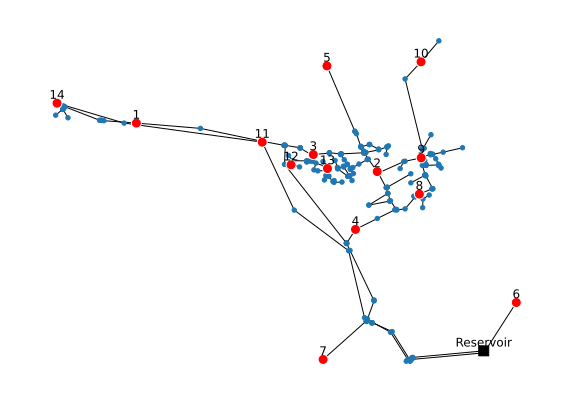

In [7]:
plot_network(...)

### Part 1.1: Preliminary model evaluation

Simulate initial (uncalibrated) network hydraulics over 4 days. We first define a function to solve network hydraulics using the `wntr` package, which we used previously in the hyraulic modelling notebook. The following tasks are performed in this function:
- Load network properties
- Modify simulation time to match operational data
- Assign h0 data at model reservoir
- Scale and apply new demand pattern from inflow data
- Option to modify pipe roughness (or HW) coefficients

<font color="blue">NB: this is done for you below. Provided the correct inputs, you do not need to replicate this function.

In [8]:
#### DO NOT CHANGE THIS ####
# hydraulic solver function
def hydraulic_solver(inp_file, d_data, h0_data, C=None, demand=False):

    # load network from wntr
    inp_file = os.path.join(net_dir, net_name)
    wn = wntr.network.WaterNetworkModel(inp_file)

    # get network properties
    reservoir_names = wn.reservoir_name_list
    junction_names = wn.junction_name_list
    link_names = wn.link_name_list

    # modify simulation time and hydraulic time step
    nt = h0_data.shape[1]
    wn.options.time.duration = (nt - 1) * 3600
    wn.options.time.hydraulic_timestep = 3600
    wn.options.time.pattern_timestep = 3600
    wn.options.time.report_timestep = 3600

    # assign reservoir data
    for (i, name) in enumerate(reservoir_names):
        wn.add_pattern(f'h0_{i}', h0_data[i])
        reservoir = wn.get_node(name)
        reservoir.head_timeseries.base_value = 1
        reservoir.head_timeseries.pattern_name = wn.get_pattern(f'h0_{i}')

    # replace demand data
    for idx, name in enumerate(junction_names):

        if any(val != 0 for val in d_data[idx, :]):
            node = wn.get_node(name)
            d_pat = d_data[idx, :]
            wn.add_pattern('d_'+name, d_pat)

            for (i, num) in enumerate(node.demand_timeseries_list):
                if i == 0:
                    node.demand_timeseries_list[i].base_value = 1
                    node.demand_timeseries_list[i].pattern_name = 'd_'+name
                else:
                    node.demand_timeseries_list[i].base_value = None
                    node.demand_timeseries_list[i].pattern_name = None

    # assign roughness (or HW) coefficients
    if C is not None:
        for name, link in wn.links():

            # check if the link is a pipe
            if isinstance(link, wntr.network.Pipe):
                link.roughness = C[link_names.index(name)]

            # check if link is a valve
            elif isinstance(link, wntr.network.Valve):
                link.minor_loss = C[link_names.index(name)]
                link.initial_setting = C[link_names.index(name)]

    # run simulation and get results
    sim = wntr.sim.EpanetSimulator(wn)
    results = sim.run_sim()

    q_sim = results.link['flowrate'].T
    h_sim = results.node['head'].T
    h_sim = h_sim[~h_sim.index.isin(reservoir_names)] # delete reservoir nodes
    d = results.node['demand'].T
    d = d[~d.index.isin(reservoir_names)] # delete reservoir nodes


    if demand == True:
        return d.to_numpy()
    else:
        return q_sim.to_numpy(), h_sim.to_numpy()

Run simulation with initial $C_0$ values.

In [ ]:
C_0 = link_df['C'].to_numpy()
_, h_0 = hydraulic_solver(...)

Compare simulated heads at sensor nodes (node indices in `sensor_idx`) with the simulated heads over the 4-day period. Visualise the results with, e.g. a boxplot of pressure residuals on the test dataset.

In [ ]:
# compute pressure residuals
residuals_0 = ...

**<u>Question 1.1:</u>** Is the current hydraulic model of EXNING accurate according to hydraulic model calibration guidelines? Comment on the results of the preliminary model evaluation and, in particular, on
* the **sign** (i.e. are heads over or underestimated in the hydraulic simulation?) of pressure/head residuals,
* the **temporal** distribution (i.e. are the residuals time/flow dependent?) of pressure/head residuals,
* and the **spatial** distribution (i.e. are all sensors affected?) of the pressure/head residuals.

Given the information you were provided about the EXNING system and the results of the preliminary model evaluation, identify the most likely sources of model errors.

<font color="red">Enter response here...

### Part 1.2: Calibration of pipe H-W coefficients

Based on the outcome of the initial comparison between measured and simulated heads at All_Sensors, you are tasked with the calibration of the hydraulic model of EXNING. Given the information provided by Anglian Water about the EXNING system, the first step is to adjust the pipe roughness (H-W) coefficients. In order to limit the number of unknown parameters (and regardless of your answer to question 1), you will assume that the status of valves in wdn.valves is known and minor/local loss coefficients are fixed to C=0.2 (fully open).

Complete the code below to calibrate the network model using the head measurements loaded previously.

#### Separate the data into train and test datasets
We suggest you use the first day worth of data (loading conditions + $h_0$ measurements) as a train dataset, and the remaining three (3) days as a test dataset.

In [ ]:
# tain data
nt_train = 24
data_train = {
    'd': ...,
    'h0': ...,
    'h_data': ...
}

# test data
data_test = {
    'd': ...,
    'h0': ...,
    'h_data': ...
}

**<u>Question 1.2:</u>** Briefly comment on the definition of the train dataset. What impact may it have on the predictive ability of your model? (i.e. what range of conditions will you confidently be able to use your model for?)

<font color="red">Enter response here...

#### Definition of the loss function
The calibration of H-W coefficients is a model fitting/parameter estimation problem. In particular, for the hydraulic model calibration problem, the loss function is defined as the mean squared error (MSE) between simulated and measured heads at sensor locations:

In [ ]:
def loss_fun(h, h_data):
    return ( 1/len(h_data.flatten()) ) * np.sum( ( h[sensor_idx, :] - h_data )**2 )

Compute MSE for `C_0` values and using the training data.

In [ ]:
h_0 = ...
mse_0 = loss_fun(...)
mse_0

**<u>Question 1.3:</u>**  Justify the choice/definition of `loss_fun`.

<font color="red">Enter response here...

#### Solve the parameter estimation problem using the train dataset

The following function is needed for the sequential convex programming (SCP) method used in this coursework. <font color="blue">As with the `hydraulic_solver` function, we provide the following code in `linear_approx_calibration` for you to use throughout this notebook.

In [ ]:
#### DO NOT CHANGE THIS ####
# compute matrices for the head loss linear approximation of the HW headloss
def linear_approx_calibration(wdn, q, C):
    # unload data
    A12 = wdn.A12
    A10 = wdn.A10
    net_info = wdn.net_info
    link_df = wdn.link_df

    K = np.zeros((net_info['np'], 1))
    n_exp = link_df['n_exp'].astype(float).to_numpy().reshape(-1, 1)
    b1_k = copy.copy(K)
    b2_k = copy.copy(K)

    for idx, row in link_df.iterrows():
        if row['link_type'] == 'pipe':
            K[idx] = 10.67 * row['length'] * (C[idx] ** -row['n_exp']) * (row['diameter'] ** -4.8704)
            b1_k[idx] = copy.copy(K[idx])
            b2_k[idx] = (-n_exp[idx] * K[idx]) / C[idx]

        elif row['link_type'] == 'valve':
            K[idx] = (8 / (np.pi ** 2 * 9.81)) * (row['diameter'] ** -4) * C[idx]
            b1_k[idx] = -n_exp[idx] * copy.copy(K[idx])
            b2_k[idx] = copy.copy(K[idx]) / C[idx]

    a11_k = np.tile(K, q.shape[1]) * np.abs(q) ** (n_exp - 1)
    b1_k = np.tile(b1_k, q.shape[1]) * np.abs(q) ** (n_exp - 1)
    b2_k = np.tile(b2_k, q.shape[1]) * np.abs(q) ** (n_exp - 1) * q

    return a11_k, b1_k, b2_k

Solve the model calibration problem using the code provided in Week 4.

In [ ]:
# unload network training data
n_exp = link_df['n_exp']
d = data_train['d']
h_data = data_train['h_data']
h0 = data_train['h0'].reshape(-1, 1).T

# define SCP problem parameters
Ki = np.inf
iter_max = 50
delta_k = 20
C_up_pipe = 200
C_lo_pipe = 1e-4

# initialise values
theta_k = ...
q_k, h_k = hydraulic_solver(...)
a11_k, b1_k, b2_k = linear_approx_calibration(...)
objval_k = loss_fun(...)

### main scp code ###
for k in range(iter_max):

    # insert code here....

**<u>Question 1.4:</u>** Describe the nature/role of the different outputs of the SCP algorithm printed above (objvalk, Ki, Deltak) and explain their trends.

<font color="red">Enter response here...

Store the solution (i.e. new coefficients `theta_k`) in $C_1$.

In [ ]:
C_1 = ...

#### Evaluate test model error
Compute the MSE and plot the pressure residuals corresponding to the test dataset.

In [ ]:
...

**<u>Question 1.5:</u>** Comment on the improvement in model accuracy (before vs. after calibration).

<font color="red">Enter response here...

#### Discuss the values of the calibrated H-W coefficients $C_1$
Visualise the values of newly calibrated coefficients $C_1$ compared to original model coefficients $C_0$.

In [ ]:
...

**<u>Question 1.6:</u>** Comment on the values of parameter estimates in $C_1$ and explain the results of the calibration without pipe grouping. Can the new model be considered calibrated?

<font color="red">Enter response here...